In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
import pathlib
import pandas as pd
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import transforms
from utilss import get_accuracy_train, get_accuracy_test, plot_curve, keep_store_dict, store_dict_to_disk
from data_loader import DataLoader1, ImageDataset
from initializers import gaussian_initializer, constant_initializer
from models import Model3, ModelM2, ModelM3, Model2, Model1, ModelAVE, Model
from test import test
from train import train

In [2]:
model1 = Model1()
model2 = Model2()
modelAVE = ModelAVE()
model2_M = ModelM2()
model3 = Model3()
model3_M = ModelM3()

In [3]:
model = Model(model1, model2, model3, modelAVE, model2_M, model3_M)
#model = model1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [4]:
num_epoch = 100
batch_size = 10
store_dict = dict()

In [5]:
dataset_test = ImageDataset("heat_maps_test_plain", "images_test", (368, 368), model.center_map)
dataset_training = ImageDataset("heat_maps_training_one", "images_training_one", (368, 368), model.center_map)
dataset_valid = ImageDataset("heat_maps_valid_plain", "images_valid", (368, 368), model.center_map)

In [6]:
# loss_function = nn.MSELoss()
# learning_rate = 0.1
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [7]:
# plt.figure(figsize = (5,5))
# image = dataset_valid[100][1][14]
# plt.imshow(image)

In [8]:
# store_dict = train(model=model, num_epochs=num_epoch, train_loader=dataset_training, test_loader=dataset_valid, store_dict=store_dict, device = device, loss_function = loss_function, optimizer=optimizer, batch_size = batch_size)
# store_dict_to_disk('store_dict.json', store_dict=store_dict)

In [9]:
# torch.save(model,'/notebooks/lk-s-2024-detekcija-poze/model23_71.pth')

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0 0
before model1 316669952
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model2 1707081728
after modelAVE 1707081728
after model2_M 1707081728
after model3 1707081728
after model3_M 1707081728
0 0 after model 1707081728


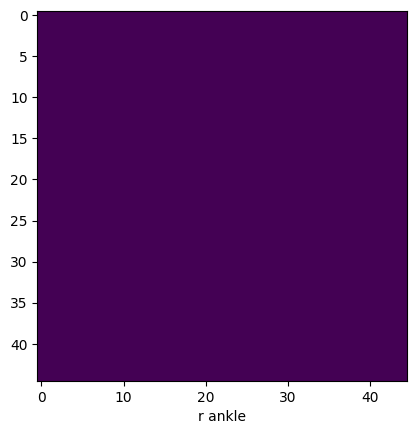

0 1
before model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model2 1707081728
after modelAVE 1707081728
after model2_M 1707081728
after model3 1707081728
after model3_M 1707081728
0 1 after model 1707081728


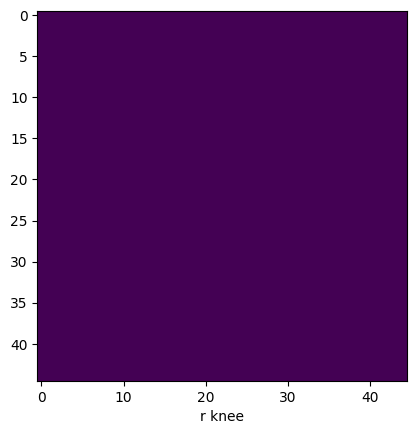

0 2
before model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model2 1707081728
after modelAVE 1707081728
after model2_M 1707081728
after model3 1707081728
after model3_M 1707081728
0 2 after model 1707081728


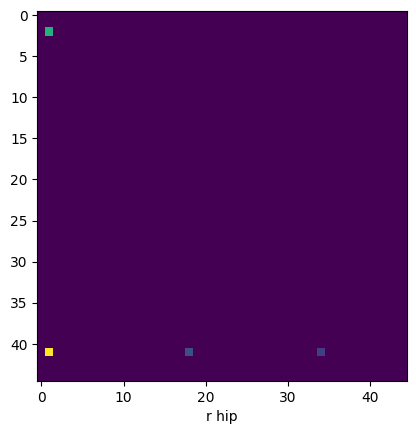

0 3
before model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model2 1707081728
after modelAVE 1707081728
after model2_M 1707081728
after model3 1707081728
after model3_M 1707081728
0 3 after model 1707081728


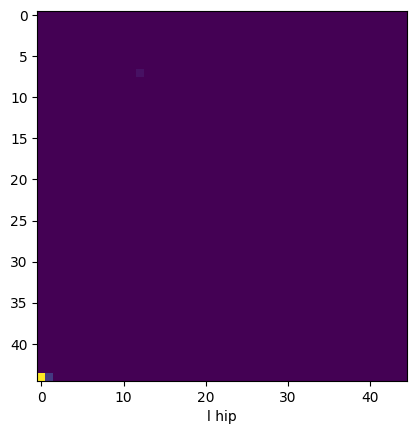

0 4
before model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model2 1707081728
after modelAVE 1707081728
after model2_M 1707081728
after model3 1707081728
after model3_M 1707081728
0 4 after model 1707081728


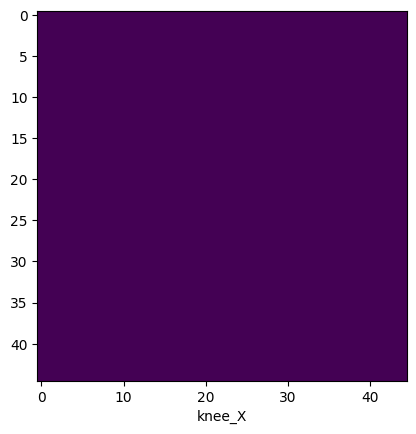

0 5
before model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model2 1707081728
after modelAVE 1707081728
after model2_M 1707081728
after model3 1707081728
after model3_M 1707081728
0 5 after model 1707081728


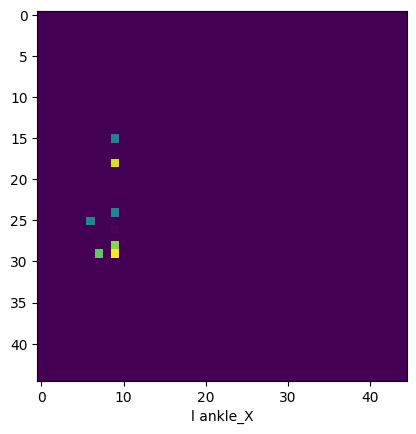

0 6
before model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model2 1707081728
after modelAVE 1707081728
after model2_M 1707081728
after model3 1707081728
after model3_M 1707081728
0 6 after model 1707081728


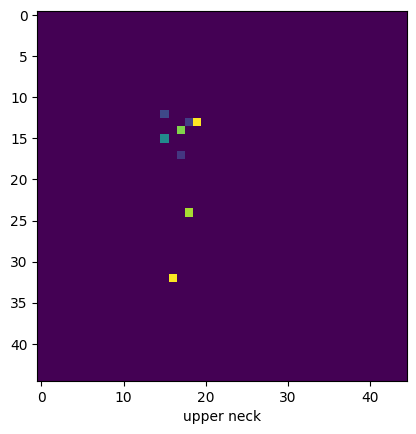

0 7
before model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model2 1707081728
after modelAVE 1707081728
after model2_M 1707081728
after model3 1707081728
after model3_M 1707081728
0 7 after model 1707081728


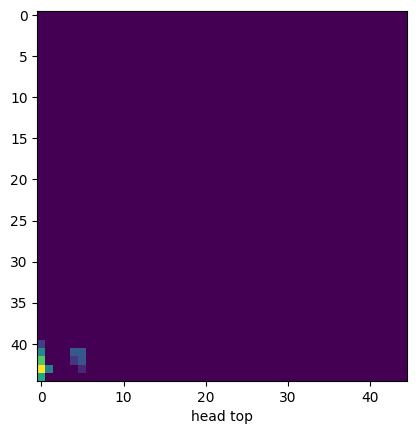

0 8
before model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model2 1707081728
after modelAVE 1707081728
after model2_M 1707081728
after model3 1707081728
after model3_M 1707081728
0 8 after model 1707081728


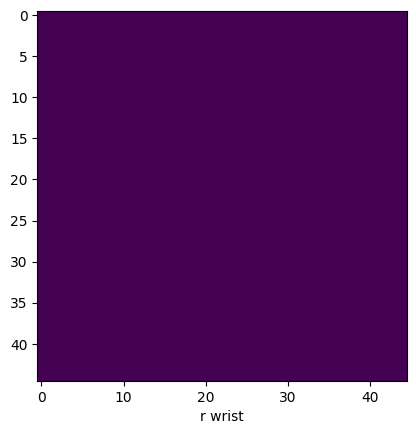

0 9
before model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model2 1707081728
after modelAVE 1707081728
after model2_M 1707081728
after model3 1707081728
after model3_M 1707081728
0 9 after model 1707081728


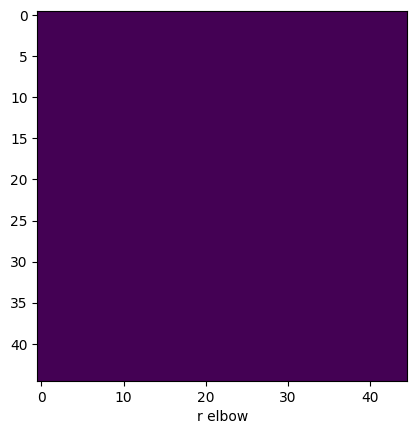

0 10
before model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model2 1707081728
after modelAVE 1707081728
after model2_M 1707081728
after model3 1707081728
after model3_M 1707081728
0 10 after model 1707081728


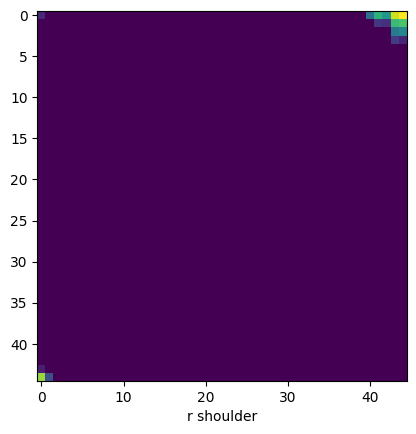

0 11
before model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model2 1707081728
after modelAVE 1707081728
after model2_M 1707081728
after model3 1707081728
after model3_M 1707081728
0 11 after model 1707081728


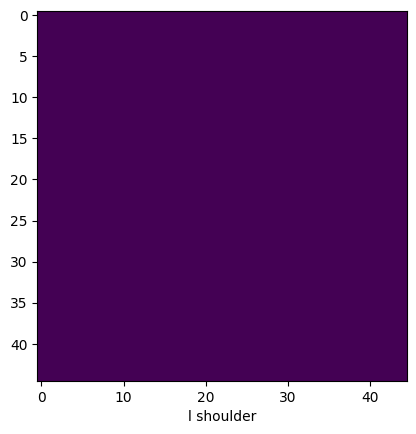

0 12
before model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model2 1707081728
after modelAVE 1707081728
after model2_M 1707081728
after model3 1707081728
after model3_M 1707081728
0 12 after model 1707081728


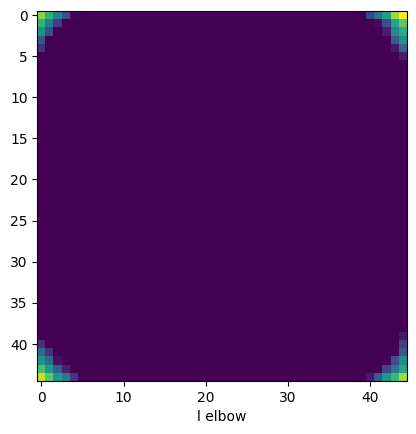

0 13
before model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model2 1707081728
after modelAVE 1707081728
after model2_M 1707081728
after model3 1707081728
after model3_M 1707081728
0 13 after model 1707081728


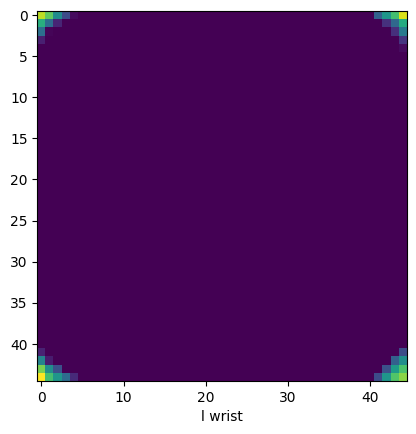

0 14
before model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model1 1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
1707081728
after model2 1707081728
after modelAVE 1707081728
after model2_M 1707081728
after model3 1707081728
after model3_M 1707081728
0 14 after model 1707081728


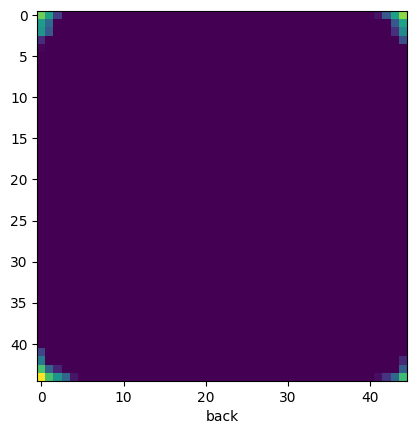

In [10]:
with torch.no_grad():
    loaded_model = torch.load('model23_71.pth')
    loaded_model = loaded_model.eval()

    input1 = dataset_training[0][0]
    a = input1.detach().numpy()
    k = np.array([a, a, a, a, a, a, a, a, a, a])
    input1 = torch.Tensor(k)
    # input1a = input1.cpu()
    # image_to_display = np.transpose(input1a, (1, 2, 0))
    # plt.imshow(image_to_display)
    # plt.show()
    input1 = input1.to(device)
    a = ['r ankle','r knee','r hip', 'l hip', 'knee_X','l ankle_X','upper neck','head top','r wrist','r elbow', 'r shoulder', 'l shoulder','l elbow','l wrist', 'back']
    for i in range(10):
        for j in range(15):
            output = loaded_model(input1)
            output = output.cpu()
            numpy_array = output.detach().numpy()
            plt.imshow(numpy_array[i][j] *255)
            plt.xlabel(a[j])
            plt.show()
        break

In [11]:
# input1 = dataset_training[7060][0]
# input1a = input1.cpu()
# image_to_display = np.transpose(input1a, (1, 2, 0))
# plt.imshow(image_to_display)
# plt.show()